# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [1]:
import random
import numpy as np
import tensorflow as tf

# Set random seeds for reproducibility
random.seed(42)          # Python's random module
np.random.seed(42)       # NumPy (used by scikit-learn)
tf.random.set_seed(42)   # TensorFlow/Keras

In [2]:
# Now proceed with other imports
import cv2
import imutils
import matplotlib.pyplot as plt
import time
import os
from os import listdir
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [3]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

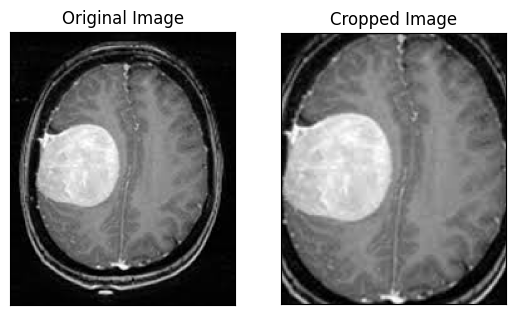

In [4]:
ex_img = cv2.imread('../../yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [5]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [6]:
augmented_path = '../../augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [7]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

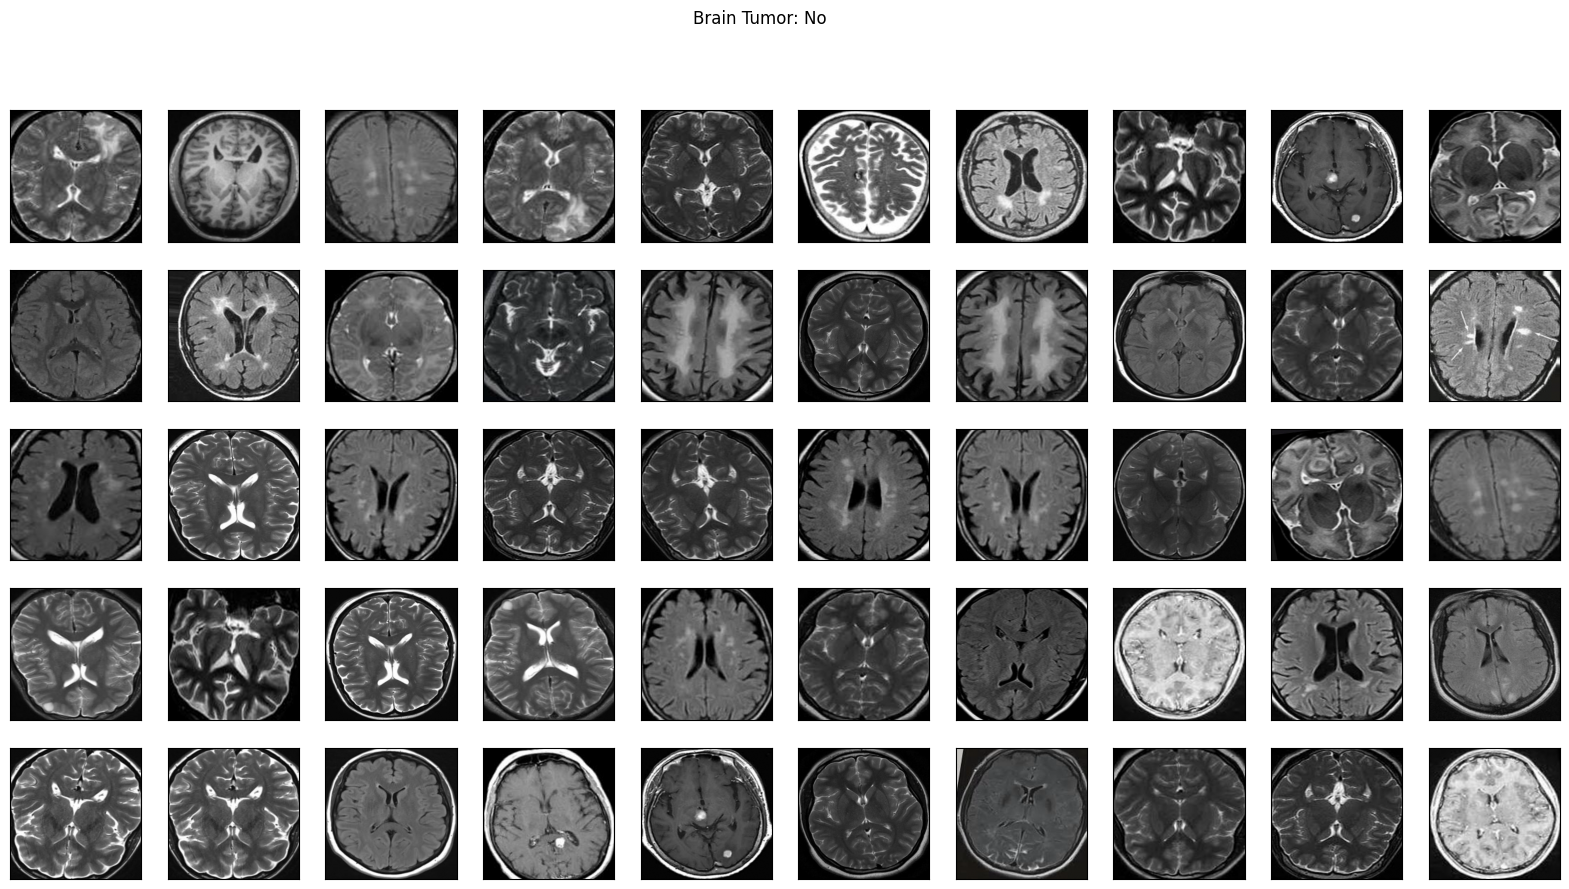

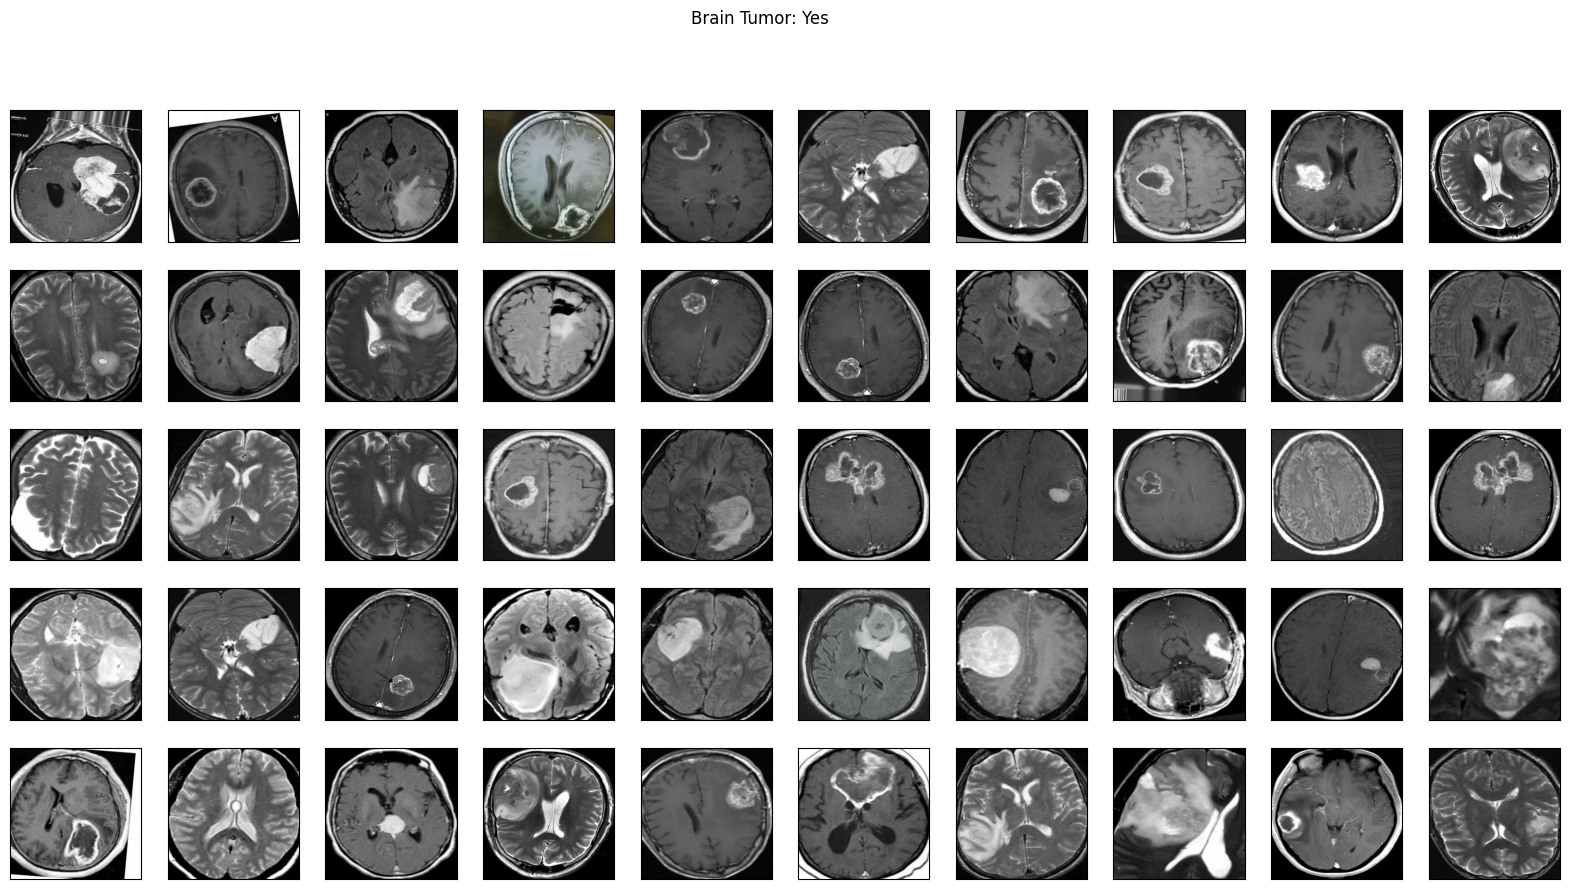

In [8]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [9]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


## Helper Functions

In [12]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

## Evaluation Functions

In [36]:
import matplotlib.pyplot as plt

def plot_metrics(history, all_histories, experiment):
    colors = {
        'Baseline': 'blue',    # Baseline model
        'Custom Model': 'red',   # Custom model
        2: 'gray',            
        3: 'red',
        4: 'purple',
        5: 'orange',
        6: 'brown',
        7: 'pink',
        8: 'green'               
    }

    if experiment == 'Dropout Rate':
        colors = {
            'Baseline': 'blue',    # Baseline model
            0.1: 'red',
            0.2: 'gray',            
            0.3: 'green',
            0.4: 'purple',
            0.5: 'orange'
        }

    _, axes = plt.subplots(1, 2, figsize=(12, 5))  

    # Loss Plot (Left)
    axes[0].plot(history['loss'], label='Train Loss (Baseline)', color=colors['Baseline'])
    axes[0].plot(history['val_loss'], label='Val Loss (Baseline)', linestyle='--', color=colors['Baseline'])
    for value, hist in all_histories.items():
        if value == "Custom Model":
            tag = ""
        else:
            tag = experiment
        axes[0].plot(hist['loss'], label=f'Train Loss ({tag} {value})', color=colors[value])
        axes[0].plot(hist['val_loss'], label=f'Val Loss ({tag} {value})', linestyle='--', color=colors[value])
    axes[0].set_title(f'Loss Comparison Across {experiment} Models')
    axes[0].legend()

    # Accuracy Plot (Right)
    axes[1].plot(history['accuracy'], label='Train Acc (Baseline)', color=colors['Baseline'])
    axes[1].plot(history['val_accuracy'], label='Val Acc (Baseline)', linestyle='--', color=colors['Baseline'])
    for value, hist in all_histories.items():
        if value == "Custom Model":
            tag = ""
        else:
            tag = experiment
        axes[1].plot(hist['accuracy'], label=f'Train Acc ({tag} {value})', color=colors[value])
        axes[1].plot(hist['val_accuracy'], label=f'Val Acc ({tag} {value})', linestyle='--', color=colors[value])
    axes[1].set_title(f'Accuracy Comparison Across {experiment} Models')
    axes[1].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()  
    plt.show()

In [14]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [15]:
def evaluate(model):
    model.metrics_names
    loss, acc = model.evaluate(x=X_test, y=y_test)

    y_val_prob = model.predict(X_val)
    f1score_val = compute_f1_score(y_val, y_val_prob)

    y_test_prob = model.predict(X_test)
    f1score = compute_f1_score(y_test, y_test_prob)

    print (f"Test Loss = {loss}")
    print (f"Test Accuracy = {acc}")
    print(f"Val F1 Score: {f1score_val}")
    print(f"Test F1 Score: {f1score}")

    return acc

# Building Model Function


In [16]:
def build_model(input_shape, layer_depth, kernel_size, dropout_rate):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    for i in range(layer_depth):
        # CONV -> BN -> RELU Block applied to X
        X = Conv2D(32, (kernel_size, kernel_size), strides = (1, 1), name = f'conv{i}')(X)
        X = BatchNormalization(axis = 3, name = f'bn{i}')(X)
        X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)

    # DROPOUT
    X = Dropout(dropout_rate, name='dropout0')(X)

    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name=f'BrainDetectionModel_layer_depth_{layer_depth}_kernel_size_{kernel_size}_dropout_rate_{dropout_rate}')
    
    return model

# Build the default model

Let's build a convolutional neural network model:

<img src='../convnet_architecture.jpg'>

Define the image shape:

In [17]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [18]:
model = build_model(IMG_SHAPE, layer_depth=1, kernel_size=7, dropout_rate=0.0)
model.summary()

Model: "BrainDetectionModel_layer_depth_1_kernel_size_7_dropout_rate_0.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout0 (Dropout)              │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

# Compile and train the model:

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Create a directory specific to each layer depth
model_dir = f"models/"
os.makedirs(model_dir, exist_ok=True)

# Static file path to ensure only the best model is saved
filepath = os.path.join(model_dir, "baseline.keras")

# Save only the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

start_time = time.time()

# Train the model without checkpointing
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint], verbose=1)

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Baseline model - Elapsed time: {hms_string(execution_time)}")

history = model.history.history
for key in history.keys():
    print(key)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5834 - loss: 1.0372 - val_accuracy: 0.6258 - val_loss: 0.6545
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.7487 - loss: 0.5232 - val_accuracy: 0.5516 - val_loss: 0.6619
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7868 - loss: 0.4467 - val_accuracy: 0.5355 - val_loss: 0.6761
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8398 - loss: 0.3771 - val_accuracy: 0.7548 - val_loss: 0.5285
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8648 - loss: 0.3425 - val_accuracy: 0.6548 - val_loss: 0.5758
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8673 - loss: 0.3252 - val_accuracy: 0.7323 - val_loss: 0.4906
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8751 - loss: 0.2953 - val_accuracy: 0.6935 - val_loss: 0.5506
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9154 - loss: 0.2333 - val_accuracy: 0.7806 - val_loss:

## Evaluate Baseline on Test Data

In [20]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

acc = evaluate(model)

# Save the the baseline as having best hyperparameter choice for now
best_layer_depth = 1
best_accuracy_layer_depth = acc

best_kernel_size = 7
best_accuracy_kernel_size = acc

best_dropout_rate = 0
best_accuracy_dropout_rate = acc

# Save baseline as current best model
best_accuracy = acc
best_model = 'Baseline'

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8210 - loss: 0.3988
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step
Test Loss = 0.40371719002723694
Test Accuracy = 0.8225806355476379
Val F1 Score: 0.7986798679867987
Test F1 Score: 0.8109965635738832


# Experiment 1: Layer Depth

We will experiment with the depth of the model by adding more convolutional layers. Specifically, we will test 1, 5 and 8 convolutional layers. We will keep a Batch Normalisation and ReLU activation function block after each convolutional layer to be consistent with the baseline model.

## Experiment 1: Build and train the models  

For each layer depth defined in the experiment, we build and train a model keeping all other architecture hyperparameters the same as the baseline model.

In [21]:
layer_depths = [5, 8]
histories = {}

for depth in layer_depths:
    model = build_model(IMG_SHAPE, layer_depth=depth, kernel_size=7, dropout_rate=0.0)
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create a directory specific to each layer depth
    model_dir = f"models/exp1/"
    os.makedirs(model_dir, exist_ok=True)

    # Static file path to ensure only the best model is saved
    filepath = os.path.join(model_dir, f"depth-{depth}.keras")

    # Save only the best model based on validation accuracy
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

    start_time = time.time()

    # Train the model without checkpointing
    model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint], verbose=1)

    end_time = time.time()
    execution_time = (end_time - start_time)
    print(f"Depth {depth} - Elapsed time: {hms_string(execution_time)}")

    # Store the history for this depth
    histories[depth] = model.history.history
    print(f"History keys for depth {depth}: {list(model.history.history.keys())}")

Model: "BrainDetectionModel_layer_depth_5_kernel_size_7_dropout_rate_0.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 232, 232, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 232, 232, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 232, 232, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 226, 226, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 226, 226, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 226, 226, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 220, 220, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 220, 220, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 220, 220, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 214, 214, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 214, 214, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 214, 214, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout0 (Dropout)              │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         5,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,617 (826.63 KB)

 Trainable params: 211,297 (825.38 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 463s 10s/step - accuracy: 0.6307 - loss: 1.1203 - val_accuracy: 0.5935 - val_loss: 1.0180
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 456s 10s/step - accuracy: 0.7447 - loss: 0.4965 - val_accuracy: 0.5774 - val_loss: 1.1456
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 453s 10s/step - accuracy: 0.8016 - loss: 0.4129 - val_accuracy: 0.5774 - val_loss: 1.3934
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 460s 10s/step - accuracy: 0.8477 - loss: 0.3386 - val_accuracy: 0.5774 - val_loss: 1.5693
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 457s 10s/step - accuracy: 0.8857 - loss: 0.2743 - val_accuracy: 0.6419 - val_loss: 0.8560
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 454s 10s/step - accuracy: 0.9242 - loss: 0.2213 - val_accuracy: 0.7355 - val_loss: 0.5201
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 455s 10s/step - accuracy: 0.9386 - loss: 0.1859 - val_accuracy: 0.7355 - val_loss: 0.5262
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 456s 10s/step - accuracy: 0.9664 - loss: 0.1436 - val_accuracy: 0.

Model: "BrainDetectionModel_layer_depth_8_kernel_size_7_dropout_rate_0.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_2                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 232, 232, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 232, 232, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 232, 232, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 226, 226, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 226, 226, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 226, 226, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 220, 220, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 220, 220, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 220, 220, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 214, 214, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 214, 214, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 214, 214, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5 (Conv2D)                  │ (None, 208, 208, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn5 (BatchNormalization)        │ (None, 208, 208, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 208, 208, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv6 (Conv2D)                  │ (None, 202, 202, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn6 (BatchNormalization)        │ (None, 202, 202, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 202, 202, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv7 (Conv2D)                  │ (None, 196, 196, 32)   │        50,208 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 361,825 (1.38 MB)

 Trainable params: 361,313 (1.38 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 711s 15s/step - accuracy: 0.5959 - loss: 1.0845 - val_accuracy: 0.5484 - val_loss: 1.1066
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 702s 15s/step - accuracy: 0.7840 - loss: 0.4638 - val_accuracy: 0.5742 - val_loss: 0.7432
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 704s 15s/step - accuracy: 0.8313 - loss: 0.3635 - val_accuracy: 0.6194 - val_loss: 0.7343
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 702s 15s/step - accuracy: 0.8738 - loss: 0.3136 - val_accuracy: 0.6323 - val_loss: 0.8312
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 704s 15s/step - accuracy: 0.9059 - loss: 0.2651 - val_accuracy: 0.7355 - val_loss: 0.8301
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 705s 15s/step - accuracy: 0.9336 - loss: 0.2130 - val_accuracy: 0.7613 - val_loss: 0.8481
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 704s 15s/step - accuracy: 0.9262 - loss: 0.2106 - val_accuracy: 0.8000 - val_loss: 0.4422
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 707s 15s/step - accuracy: 0.9433 - loss: 0.1869 - val_accuracy: 0.

## Experiment 1: Plot Metrics for Training and Validation Sets

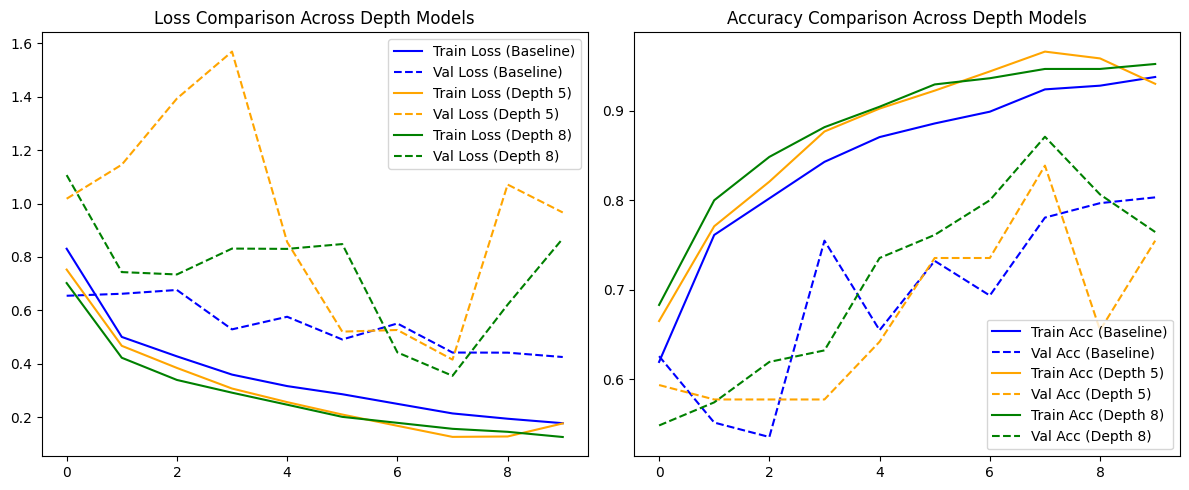

In [22]:
plot_metrics(history, histories, experiment='Depth')

## Experiment 1: Evaluation on Test Set

In [23]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

depth_models_dir = 'models/exp1'
depth_models_paths = [f for f in listdir(depth_models_dir) if f.endswith('.keras')]
for path in depth_models_paths:
    depth = str(path.split('-')[1].split('.')[0])
    model = load_model(f"{depth_models_dir}/{path}")
    models['Depth '+depth] = model

# Save the best layer depth according to the accuracy of different models
for name, model in models.items():
    print(f"----------------- Evaluating {name} -----------------")
    acc = evaluate(model)
    if name == "Baseline":
        continue
    if acc > best_accuracy_layer_depth:
        best_accuracy_layer_depth = acc
        best_layer_depth = int(name.split(' ')[-1])

----------------- Evaluating Baseline -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8210 - loss: 0.3988
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
Test Loss = 0.40371719002723694
Test Accuracy = 0.8225806355476379
Val F1 Score: 0.7986798679867987
Test F1 Score: 0.8109965635738832
----------------- Evaluating Depth 5 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8818 - loss: 0.3403
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Test Loss = 0.33064261078834534
Test Accuracy = 0.8838709592819214
Val F1 Score: 0.84375
Test F1 Score: 0.8881987577639752
----------------- Evaluating Depth 8 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8365 - loss: 0.3808
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step
Test Loss = 0.3725321590900421
Test Accuracy = 0.8483871221542358
Val F1 Score: 0.8809523809523809
Test F1 Score: 0.85

# Experiment 2: Kernel Size

For the second experiment we will be modifying the size of the kernel filter used in convolutions. We will test 3x3, 5x5 and 7x7 kernel sizes. The 3x3 and 5x5 sizes are inspired on the literature. The 7x7 size is taken from the original baseline model for comparison.

Stride is kept constant at (1, 1) to be consistent with the baseline model and because it is common in the literature.

## Experiment 2: Build and train the models  

For each kernel size defined in the experiment, we build and train a model keeping all other architecture hyperparameters the same as the baseline model.

In [24]:
kernel_sizes = [3, 5]
histories = {}

for kernel_size in kernel_sizes:
    model = build_model(IMG_SHAPE, layer_depth=1, kernel_size=kernel_size, dropout_rate=0.0)
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create a directory for this experiment
    model_dir = f"models/exp2/"
    os.makedirs(model_dir, exist_ok=True)

    # Static file path to ensure only the best model is saved
    filepath = os.path.join(model_dir, f"kernel_size-{kernel_size}.keras")

    # Save only the best model based on validation accuracy
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

    start_time = time.time()

    # Train the model without checkpointing
    model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint], verbose=1)

    end_time = time.time()
    execution_time = (end_time - start_time)
    print(f"kernel Size {kernel_size} - Elapsed time: {hms_string(execution_time)}")

    # Store the history for this kernel size
    histories[kernel_size] = model.history.history
    print(f"History keys for kernel size {kernel_size}: {list(model.history.history.keys())}")

Model: "BrainDetectionModel_layer_depth_1_kernel_size_3_dropout_rate_0.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_3                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 242, 242, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 242, 242, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 242, 242, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout0 (Dropout)              │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         7,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,225 (32.13 KB)

 Trainable params: 8,161 (31.88 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5788 - loss: 1.1414 - val_accuracy: 0.6710 - val_loss: 0.6645
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.7620 - loss: 0.5031 - val_accuracy: 0.4710 - val_loss: 0.6874
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8109 - loss: 0.4217 - val_accuracy: 0.4613 - val_loss: 0.6886
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8445 - loss: 0.3732 - val_accuracy: 0.5355 - val_loss: 0.6521
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8512 - loss: 0.3569 - val_accuracy: 0.6097 - val_loss: 0.6183
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8654 - loss: 0.3269 - val_accuracy: 0.6871 - val_loss: 0.5726
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8892 - loss: 0.2987 - val_accuracy: 0.6935 - val_loss: 0.5480
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9031 - loss: 0.2826 - val_accuracy: 0.7548 - val_loss:

Model: "BrainDetectionModel_layer_depth_1_kernel_size_5_dropout_rate_0.0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_4                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 240, 240, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 240, 240, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 240, 240, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout0 (Dropout)              │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         7,201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,761 (38.13 KB)

 Trainable params: 9,697 (37.88 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.5799 - loss: 1.3270 - val_accuracy: 0.5290 - val_loss: 0.6830
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7515 - loss: 0.5067 - val_accuracy: 0.4710 - val_loss: 0.7116
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8117 - loss: 0.4101 - val_accuracy: 0.5097 - val_loss: 0.6783
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8455 - loss: 0.3637 - val_accuracy: 0.6387 - val_loss: 0.6074
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8721 - loss: 0.3186 - val_accuracy: 0.6774 - val_loss: 0.5739
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8926 - loss: 0.2869 - val_accuracy: 0.7613 - val_loss: 0.5000
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.9026 - loss: 0.2631 - val_accuracy: 0.8161 - val_loss: 0.4400
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9120 - loss: 0.2437 - val_accuracy: 0.8323 - val_loss:

## Experiment 2: Plot Metrics for Training and Validation Sets

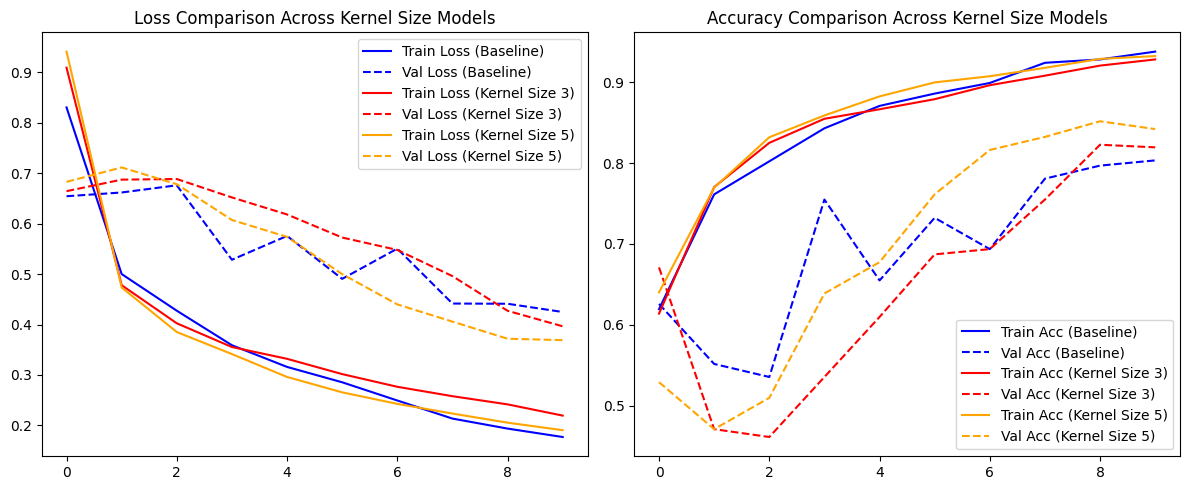

In [25]:
plot_metrics(history, histories, experiment='Kernel Size')

## Experiment 2: Evaluation on Test Set

In [26]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

kernel_size_models_dir = 'models/exp2'
kernel_size_models_paths = [f for f in listdir(kernel_size_models_dir) if f.endswith('.keras')]
for path in kernel_size_models_paths:
    kernel_size = str(path.split('-')[1].split('.')[0])
    model = load_model(f"{kernel_size_models_dir}/{path}")
    models['Kernel Size '+kernel_size] = model

# Save the best kernel size according to the accuracy of different models
for name, model in models.items():
    print(f"----------------- Evaluating {name} -----------------")
    acc = evaluate(model)
    if name == "Baseline":
        continue
    if acc > best_accuracy_kernel_size:
        best_accuracy_kernel_size = acc
        best_kernel_size = int(name.split(' ')[-1])

----------------- Evaluating Baseline -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.8210 - loss: 0.3988
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step
Test Loss = 0.40371719002723694
Test Accuracy = 0.8225806355476379
Val F1 Score: 0.7986798679867987
Test F1 Score: 0.8109965635738832
----------------- Evaluating Kernel Size 3 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.8074 - loss: 0.4085
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step
Test Loss = 0.39277493953704834
Test Accuracy = 0.8322580456733704
Val F1 Score: 0.8297213622291022
Test F1 Score: 0.8364779874213837
----------------- Evaluating Kernel Size 5 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.8456 - loss: 0.3874
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
Test Loss = 0.3667454421520233
Test Accuracy = 0.8580645322799683
Val F1 Score: 0.8

# Experiment 3: Dropout Rate

In this third experiment we will be seeing how different dropout rates affect model performance when identifying the presence of a brain tumor. We will test the baseline model with no dropout and compare it to adding a dropout layer of 0.1 and 0.3. 

## Experiment 3: Build and train the models  

For each dropout rate defined in the experiment, we build and train a model. We will keep all other architecture hyperparameters the same as the baseline model as a control. 

In [27]:
dropout_rates = [0.1, 0.3]
histories = {}

for dropout_rate in dropout_rates:
    model = build_model(IMG_SHAPE, layer_depth=1, kernel_size=7, dropout_rate=dropout_rate)
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create a directory for this experiment
    model_dir = f"models/exp3/"
    os.makedirs(model_dir, exist_ok=True)

    # Static file path to ensure only the best model is saved
    filepath = os.path.join(model_dir, f"dropout_rate-{dropout_rate}.keras")

    # Save only the best model based on validation accuracy
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

    start_time = time.time()

    # Train the model without checkpointing
    model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint], verbose=1)

    end_time = time.time()
    execution_time = (end_time - start_time)
    print(f"Dropout Rate {dropout_rate} - Elapsed time: {hms_string(execution_time)}")

    # Store the history for this dropout rate
    histories[dropout_rate] = model.history.history
    print(f"History keys for dropout rate {dropout_rate}: {list(model.history.history.keys())}")

Model: "BrainDetectionModel_layer_depth_1_kernel_size_7_dropout_rate_0.1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_5                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout0 (Dropout)              │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5656 - loss: 0.9956 - val_accuracy: 0.6710 - val_loss: 0.6348
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7516 - loss: 0.5140 - val_accuracy: 0.7419 - val_loss: 0.6059
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8010 - loss: 0.4403 - val_accuracy: 0.7806 - val_loss: 0.5499
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8367 - loss: 0.3895 - val_accuracy: 0.7839 - val_loss: 0.5068
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8505 - loss: 0.3670 - val_accuracy: 0.8161 - val_loss: 0.4576
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8712 - loss: 0.3388 - val_accuracy: 0.7613 - val_loss: 0.4848
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8883 - loss: 0.2863 - val_accuracy: 0.7806 - val_loss: 0.4674
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8696 - loss: 0.2821 - val_accuracy: 0.8387 - val_loss:

Model: "BrainDetectionModel_layer_depth_1_kernel_size_7_dropout_rate_0.3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_6                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout0 (Dropout)              │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5642 - loss: 1.1400 - val_accuracy: 0.6258 - val_loss: 0.6628
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.6982 - loss: 0.5817 - val_accuracy: 0.5484 - val_loss: 0.6642
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7473 - loss: 0.5239 - val_accuracy: 0.6645 - val_loss: 0.5981
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7926 - loss: 0.4615 - val_accuracy: 0.7839 - val_loss: 0.4921
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8052 - loss: 0.4610 - val_accuracy: 0.7548 - val_loss: 0.5009
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.7931 - loss: 0.4590 - val_accuracy: 0.8000 - val_loss: 0.4211
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8356 - loss: 0.4187 - val_accuracy: 0.7968 - val_loss: 0.4141
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8334 - loss: 0.3653 - val_accuracy: 0.8065 - val_loss:

## Experiment 3: Plot Metrics for Training and Validation Sets

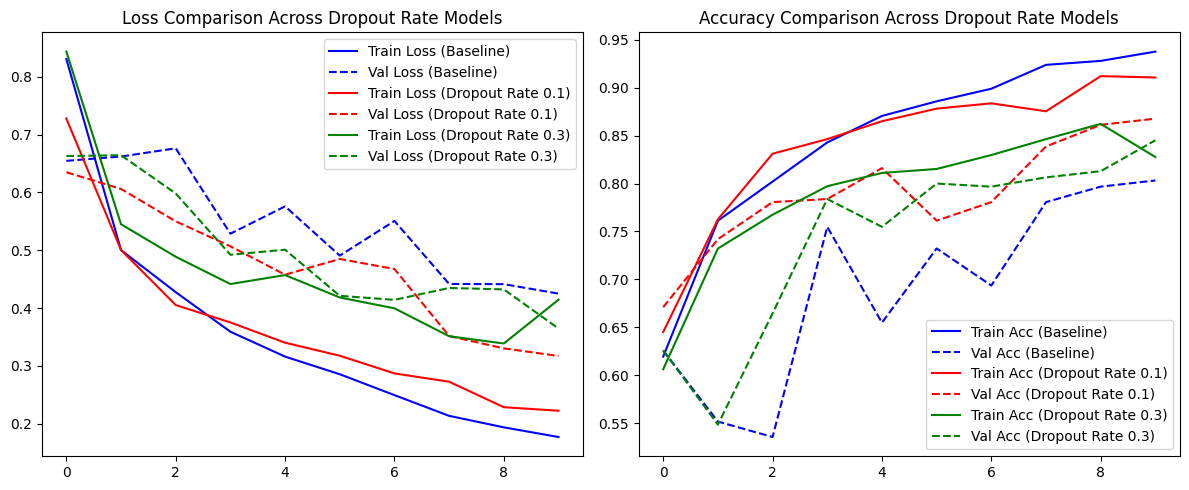

In [28]:
plot_metrics(history, histories, experiment='Dropout Rate')

## Experiment 3: Evaluation on Test Set

In [29]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

dropout_rates_models_dir = 'models/exp3'
dropout_rates_models_paths = [f for f in listdir(dropout_rates_models_dir) if f.endswith('.keras')]
for path in dropout_rates_models_paths:
    dropout_rate = str('.'.join(path.split('-')[1].split('.')[:-1]))
    model = load_model(f"{dropout_rates_models_dir}/{path}")
    models['Dropout Rate '+dropout_rate] = model

# Save the best dropout rate according to the accuracy of different models
for name, model in models.items():
    print(f"----------------- Evaluating {name} -----------------")
    acc = evaluate(model)
    if name == "Baseline":
        continue
    if acc > best_accuracy_dropout_rate:
        best_accuracy_dropout_rate = acc
        best_dropout_rate = float(name.split(' ')[-1])

----------------- Evaluating Baseline -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8210 - loss: 0.3988
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step
Test Loss = 0.40371719002723694
Test Accuracy = 0.8225806355476379
Val F1 Score: 0.7986798679867987
Test F1 Score: 0.8109965635738832
----------------- Evaluating Dropout Rate 0.1 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.8535 - loss: 0.3276
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
Test Loss = 0.2930401563644409
Test Accuracy = 0.8774193525314331
Val F1 Score: 0.888283378746594
Test F1 Score: 0.8888888888888888
----------------- Evaluating Dropout Rate 0.3 -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8473 - loss: 0.3521
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step
Test Loss = 0.34226199984550476
Test Accuracy = 0.8483871221542358
Val F1 Score

# Build Custom Model

Following the experiments we conducted to find the best independent architecture choices, we will combine the best performing ones into a single model and compare this new model's performance to the baseline model and the models from the experiments.

In [30]:
# Take the best performing hyperparameters from the controlled experiments 
layer_depth = best_layer_depth
kernel_size = best_kernel_size
dropout_rate = best_dropout_rate

if layer_depth == 1 and kernel_size == 7 and dropout_rate == 0:
    print("The baseline model is the best model.")
else:
    print(f"Custom model has layer depth of {layer_depth}, kernel size of {kernel_size}, and dropout rate of {dropout_rate}.")
    model = build_model(IMG_SHAPE, layer_depth=layer_depth, kernel_size=kernel_size, dropout_rate=dropout_rate)
    model.summary()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Create a directory for this experiment
    model_dir = f"models/"
    os.makedirs(model_dir, exist_ok=True)

    # Static file path to ensure only the custom model is saved
    filepath = os.path.join(model_dir, f"custom_model_layer_depth-{layer_depth}_kernel_size-{kernel_size}_dropout_rate-{dropout_rate}.keras")

    # Save only the custom model based on validation accuracy
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

    start_time = time.time()

    # Train the model without checkpointing
    model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), shuffle=True, callbacks=[checkpoint], verbose=1)

    end_time = time.time()
    execution_time = (end_time - start_time)
    print(f"Dropout Rate {dropout_rate} - Elapsed time: {hms_string(execution_time)}")

    # Store the history for this dropout rate
    history_custom_model = model.history.history
    print(f"History keys for custom model: {list(model.history.history.keys())}")

Custom model has layer depth of 5, kernel size of 5, and dropout rate of 0.1.


Model: "BrainDetectionModel_layer_depth_5_kernel_size_5_dropout_rate_0.1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_7                │ (None, 244, 244, 3)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 240, 240, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 240, 240, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 240, 240, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 236, 236, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 236, 236, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 236, 236, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 232, 232, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 232, 232, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 232, 232, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 228, 228, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 228, 228, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 228, 228, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 224, 224, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_22 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout0 (Dropout)              │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,873 (437.00 KB)

 Trainable params: 111,553 (435.75 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 368s 8s/step - accuracy: 0.6004 - loss: 1.2808 - val_accuracy: 0.5710 - val_loss: 0.6485
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 359s 8s/step - accuracy: 0.7142 - loss: 0.5458 - val_accuracy: 0.5903 - val_loss: 0.7491
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 361s 8s/step - accuracy: 0.7917 - loss: 0.4580 - val_accuracy: 0.5935 - val_loss: 0.8388
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 354s 8s/step - accuracy: 0.8264 - loss: 0.3880 - val_accuracy: 0.6290 - val_loss: 0.6774
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 352s 8s/step - accuracy: 0.8578 - loss: 0.3368 - val_accuracy: 0.6548 - val_loss: 0.6265
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 354s 8s/step - accuracy: 0.8860 - loss: 0.2824 - val_accuracy: 0.6935 - val_loss: 0.6226
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 354s 8s/step - accuracy: 0.9020 - loss: 0.2429 - val_accuracy: 0.7613 - val_loss: 0.4821
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 354s 8s/step - accuracy: 0.9241 - loss: 0.2256 - val_accuracy: 0.8355 - v

## Plot metrics for training and validation sets for baseline and custom models

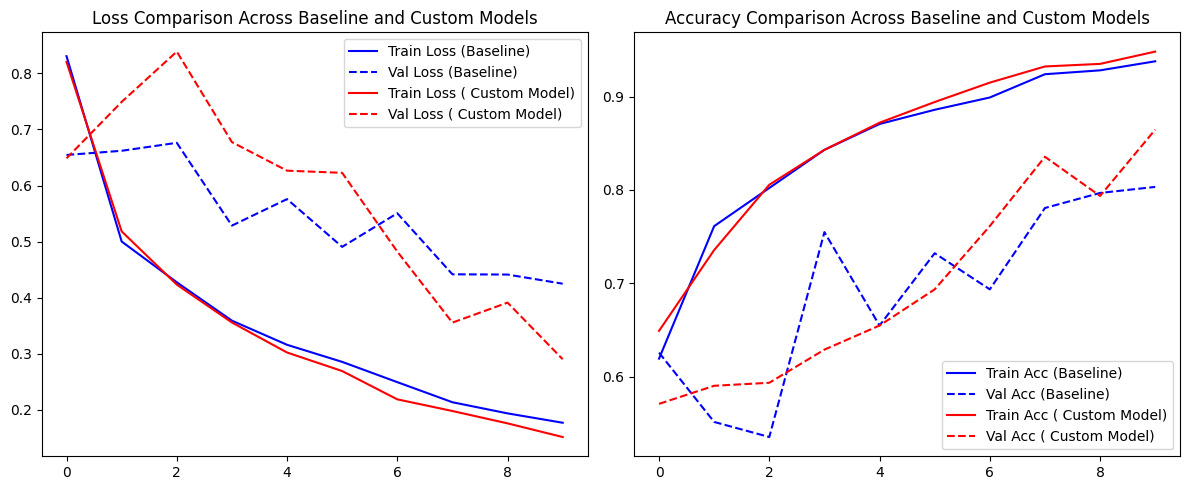

In [37]:
if layer_depth == 1 and kernel_size == 7 and dropout_rate == 0:
    plot_metrics(history, {}, experiment='Baseline')
else:
    plot_metrics(history, {'Custom Model': history_custom_model}, experiment='Baseline and Custom')

## Evaluation on Test Set


In [38]:
baseline_path = 'models/baseline.keras'
model = load_model(baseline_path)
models = {'Baseline': model}

if layer_depth != 1 or kernel_size != 7 or dropout_rate != 0:
    custom_path = f'models/custom_model_layer_depth-{layer_depth}_kernel_size-{kernel_size}_dropout_rate-{dropout_rate}.keras'
    model = load_model(custom_path)
    models['Custom Model'] = model

    for name, model in models.items():
        print(f"----------------- Evaluating {name} -----------------")
        acc = evaluate(model)
        if name == "Baseline":
            continue
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = name
else:
    print("The baseline model is the best model.")

----------------- Evaluating Baseline -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8210 - loss: 0.3988
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
Test Loss = 0.40371719002723694
Test Accuracy = 0.8225806355476379
Val F1 Score: 0.7986798679867987
Test F1 Score: 0.8109965635738832
----------------- Evaluating Custom Model -----------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8331 - loss: 0.3546
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
Test Loss = 0.33116239309310913
Test Accuracy = 0.8483871221542358
Val F1 Score: 0.8877005347593583
Test F1 Score: 0.8712328767123287


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [39]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [40]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [41]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 51.21107266435986%, number of pos examples: 740
Percentage of negative examples: 48.78892733564014%, number of neg examples: 705
Validation Data:
Number of examples: 310
Percentage of positive examples: 57.41935483870968%, number of pos examples: 178
Percentage of negative examples: 42.58064516129032%, number of neg examples: 132
Testing Data:
Number of examples: 310
Percentage of positive examples: 53.87096774193548%, number of pos examples: 167
Percentage of negative examples: 46.12903225806452%, number of neg examples: 143


As expected, the percentage of positive examples are around 50%.

# Conclusion:

#### Our new custom models performance on the test set:<br>

**85%** accuracy on the **test set**.<br>
**0.87** f1 score on the **test set**.<br>

These resutls are very good considering that the data is balanced.

#### We can make a table for the performance metrics of the baseline against our new custom model:<br>

**Performance Table:**

| Metric    | Baseline Model | Our Custom Model |
| --------- | -------------- | -------- |
| Accuracy (Validation) | 80%            | 86%      |
| Accuracy (Test)       | 82%            | 85%      |
| F1 score (Validation) | 0.80           | 0.89     |
| F1 score (Test)       | 0.81           | 0.87     |